In [1]:
import matplotlib.pyplot as plt, numpy as np
from nuscenes.nuscenes import NuScenes, NuScenesExplorer
import json
import os
import cv2
from tqdm import tqdm

USE_DETECTOR_JSON = False
SCENE_INDEX = 3
DETECTOR_JSON_FILE = "/home/captainlevi/Documents/UCSD_lab_project/AVL/MOT/codes/Poly-MOT/result/custom/json_dump/results.json"

In [2]:
# NuScenes path
if USE_DETECTOR_JSON == False:
    DATASET_VERSION = 'v1.0-mini'
else:
    DATASET_VERSION = 'v1.0-trainval'

nusc = NuScenes(version=DATASET_VERSION, dataroot='/home/captainlevi/Documents/UCSD_lab_project/AVL/data/nuScenes_dataset/nuScenes/' + DATASET_VERSION, verbose=True)
print("Using NuScenes dataset version: ", DATASET_VERSION)
# nuscExp = NuScenesExplorer(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.260 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.
Using NuScenes dataset version:  v1.0-mini


**GET ALL ANNOTATIONS OF A SCENE**

In [3]:
def get_scene_annotations_nuscenes(scene_index):
    my_scene = nusc.scene[scene_index]
    first_sample_token = my_scene['first_sample_token']

    current_sample_token = first_sample_token
    result_dict = {}
    scene_sample_tokens = []

    while True:
        scene_sample_tokens.append(current_sample_token)
        current_sample = nusc.get('sample', current_sample_token)
        annotations = current_sample['anns']

        sample_annotations = []
        for annotation_token in annotations:
            annotation_metadata = nusc.get('sample_annotation', annotation_token)
            annotation_metadata["tracking_id"] = 1
            sample_annotations.append(annotation_metadata)
        result_dict[current_sample_token] = sample_annotations
        
        next_sample_token = current_sample['next']
        if next_sample_token == '':
            break
        current_sample_token = next_sample_token

    return result_dict, scene_sample_tokens

In [4]:
def get_scene_annotations_detector(detector_json_file):
    with open(detector_json_file) as f:
        results = json.load(f)

    scene_sample_tokens = list(results["results"].keys())

    return results["results"], scene_sample_tokens

In [5]:
if USE_DETECTOR_JSON == False:
    result_dict, scene_sample_tokens = get_scene_annotations_nuscenes(SCENE_INDEX)
else:
    result_dict, scene_sample_tokens = get_scene_annotations_detector(DETECTOR_JSON_FILE)

**VISUALIZE TRACKING 3D BOUNDING BOXES**

In [6]:
from nuscenes_utils import render_sample_data_custom

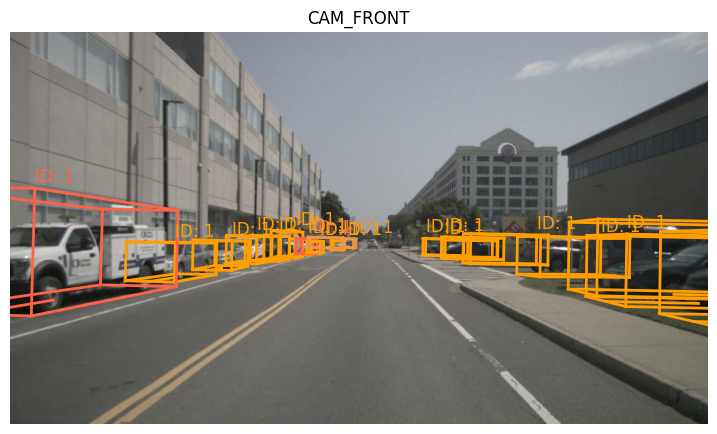

In [7]:
sample_token = scene_sample_tokens[2]

annotations_list = result_dict[sample_token]
sample_data_token = nusc.get('sample', sample_token)['data']['CAM_FRONT']

results_out_path_folder = "/home/captainlevi/Documents/UCSD_lab_project/AVL/MOT/codes/Poly-MOT/result/custom/"

render_sample_data_custom(sample_data_token, annotations_list, nusc, 
                          out_path = results_out_path_folder + sample_data_token + '.png', verbose = True)

**MAKE SCENE VIDEO**

In [8]:
from vis_utils import scene_samples_render, generate_video

In [9]:
FPS = 1
result_folder = "/home/captainlevi/Documents/UCSD_lab_project/AVL/MOT/codes/Poly-MOT/result/custom/"

In [10]:
if USE_DETECTOR_JSON == False:
    images_folder = os.path.join(result_folder, DATASET_VERSION, str(SCENE_INDEX), 'images')
    video_folder = os.path.join(result_folder, DATASET_VERSION, str(SCENE_INDEX), 'videos')
else:
    images_folder = os.path.join(result_folder, 'detector', 'images')
    video_folder = os.path.join(result_folder, 'detector', 'videos')

if not os.path.exists(images_folder):
    os.makedirs(images_folder)
if not os.path.exists(video_folder):
    os.makedirs(video_folder)

In [11]:
# render images with bounding boxes for all samples
img_size, img_array = scene_samples_render(scene_sample_tokens, result_dict, nusc, images_folder)

100%|██████████| 41/41 [00:00<00:00, 44.02it/s]


In [12]:
# write video in mp4
video_path = os.path.join(video_folder, str(SCENE_INDEX) + '.mp4')
generate_video(img_array, video_path, FPS, img_size)

100%|██████████| 41/41 [00:00<00:00, 211.47it/s]
